In [1]:
from fastai.vision.all import *
import timm

/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_dir = Path("../data")
img_dir = data_dir/"images_preproc"
model_dir = data_dir/"model"

In [4]:
print(len(get_image_files(img_dir)))

24721


In [6]:
def get_dls(bs, size):
    dl = ImageDataLoaders.from_folder(
        path=img_dir, 
        valid_pct=0.2, 
        bs=bs, 
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=size, min_scale=0.85))
    return(dl)

In [7]:
dls = get_dls(128, 112)

In [6]:
#dls_300.show_batch()

In [9]:
learn = vision_learner(dls, 
                       "efficientnet_b0",
                       pretrained=True,
                       normalize=True,
                       #cbs=[MixUp(1.)],
                       #loss_func=LabelSmoothingCrossEntropy(),
                       loss_func=CrossEntropyLossFlat(),
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [10]:
learn.fit_one_cycle(10, 3e-3)


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.350209,4.029744,0.108819,0.300971,00:30
1,4.061984,3.344808,0.217840,0.468244,00:29
2,3.300241,2.877160,0.282362,0.583131,00:29
3,2.903646,2.617445,0.335963,0.639159,00:30
4,2.604288,2.446238,0.371764,0.674960,00:29
5,2.375167,2.315460,0.401294,0.698220,00:30
6,2.182670,2.222458,0.426375,0.713794,00:31
7,2.058155,2.172171,0.438714,0.722896,00:30
8,1.936564,2.142193,0.449838,0.728155,00:30
9,1.891007,2.139097,0.446804,0.731392,00:30


In [ ]:
#progressive resizing
#label smooth on last learner

In [11]:
learn.dls = get_dls(64, 224)
learn.loss_func = LabelSmoothingCrossEntropy()
learn.fit_one_cycle(10, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.684852,2.238811,0.584749,0.843851,00:49
1,2.500333,2.170443,0.596278,0.853358,00:49
2,2.387727,2.142231,0.602751,0.853358,00:49
3,2.353048,2.132947,0.608010,0.853762,00:49
4,2.243342,2.111205,0.610841,0.855583,00:48
5,2.158607,2.099370,0.615494,0.857807,00:48
6,2.126980,2.073329,0.621966,0.861448,00:48
7,2.077647,2.062843,0.629248,0.863066,00:49
8,2.035818,2.059807,0.628034,0.861853,00:50
9,2.007335,2.062299,0.626820,0.861650,00:49


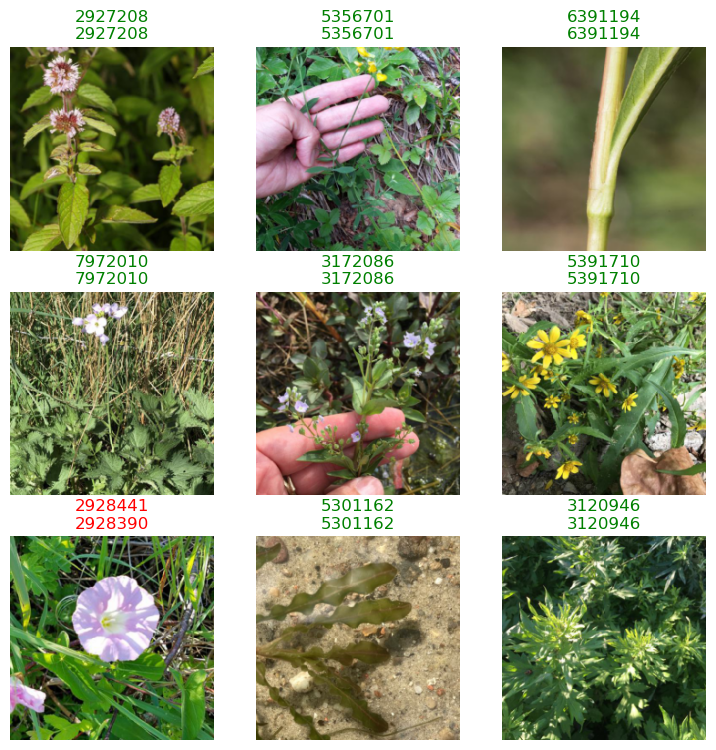

In [14]:
learn.show_results()


In [18]:
model_dir/"resnet_18_100.export"

Path('../data/model/resnet_18_100.export')

In [13]:
learn.export("effnet_b0.export")